In [1]:
import sys
if False: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else: # Local
    root = './'
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda:'+str(torch.cuda.device_count()-1))
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [2]:
import importlib
import util
importlib.reload(util)
from util import *

In [11]:
from models import *

In [4]:
loss = torch.nn.MSELoss()
def train_it(dataset, model,
             OPTIM=torch.optim.Adam, learning_rate = 1e-1, batch_size=20,
             Npast=1, Nfuture=1):
    optimizer = OPTIM(model.parameters(), lr=learning_rate)
    Nepoch = 100
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Nbatch = batch_size #Ntotal//10
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset, Nfuture=Nfuture)
        # We iterate multiple times:
        y_pred = model(xx)+xx
        L = loss(y_pred,yy[:,(0,),:])
        for i in range(1,Nfuture):
            h = y_pred
            y_pred = model(h)+h
            L += loss(y_pred, yy[:,(i,),:])
        # Optimize:
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        # Make stats:
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

In [5]:
dataname = "burgers"
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
Ntraj,Nt,Nx = dataset.shape

In [6]:
Ntraj,Nt,Nx

(20, 100, 41)

In [7]:
stash = {}

In [12]:
for act in ["ReLU","CELU",]:#"LeakyReLU","ReLU",Tanh
    for depth in [3,]:
        for channels in [5,10]:
            for nstep in [2,3,4,]:
                for width in [5]:
                    key = (width,act,depth,channels, nstep)
                    try:
                        entry = stash[key]
                        print("Resuming training of ",key)
                    except KeyError:
                        entry = { 'model'   : LeakyDeepStencil(Nx,width,channels,depth,act).to(device),
                                'results' : np.empty((0,2)) }
                        print("Training new ",key)
                    model = entry['model']
                    results = entry['results']
                    tr_res = train_it(dataset,model,learning_rate=1.0e-3, batch_size=50, Nfuture=nstep)
                    results = np.append(results, tr_res, axis=0)
                    stash[key] = {'model':model,'results':results}
with open(root+f"/models_multi_wide_{dataname}.pkl","wb") as f:
    torch.save(stash,f)

Training new  (5, 'ReLU', 3, 5, 2)
3839 0.0038222726434469223
7679 0.0008776660542935133
11519 0.0003487876965664327
15359 0.0008082730928435922
19199 0.0021877181716263294
23039 0.0020294231362640858
26879 0.0019232258200645447
30719 0.000770165235735476
34559 0.0010245193261653185
38399 0.002464082557708025
Training new  (5, 'ReLU', 3, 5, 3)
3799 0.0018174168653786182
7599 0.00463495496660471
11399 0.001433814875781536
15199 0.004107852000743151
18999 0.0022302898578345776
22799 0.0027438742108643055
26599 0.003699094522744417
30399 0.00928425882011652
34199 0.002459361683577299
37999 0.006560731213539839
Training new  (5, 'ReLU', 3, 5, 4)
3759 0.0038859585765749216
7519 0.004644482396543026
11279 0.0031231630127876997
15039 0.0032236548140645027
18799 0.0065231649205088615
22559 0.0042976681143045425
26319 0.0029538930393755436
30079 0.006717606447637081
33839 0.0061422125436365604
37599 0.002036908408626914
Training new  (5, 'ReLU', 3, 10, 2)
3839 0.0005720109329558909
7679 0.00090

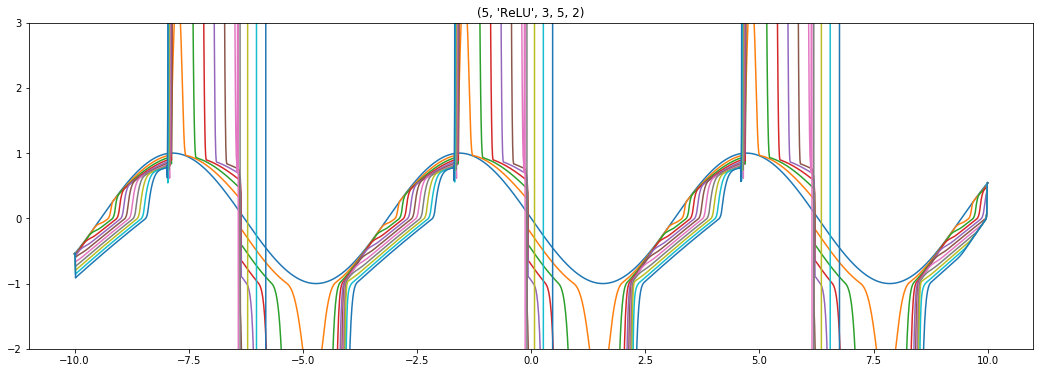

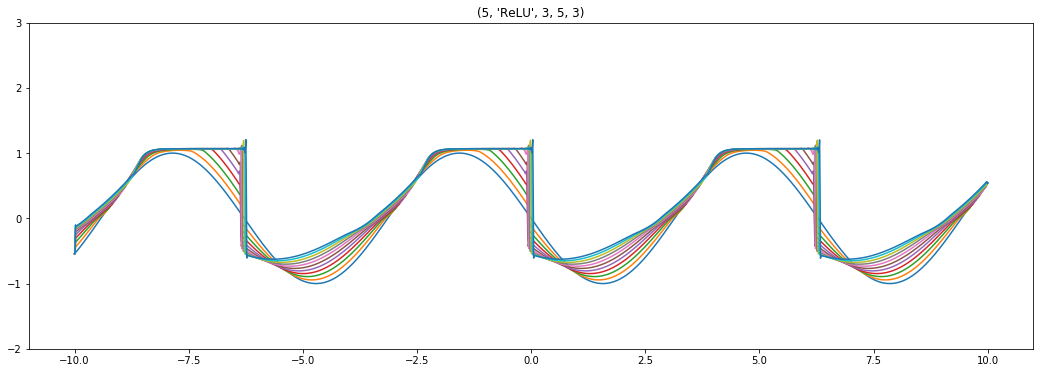

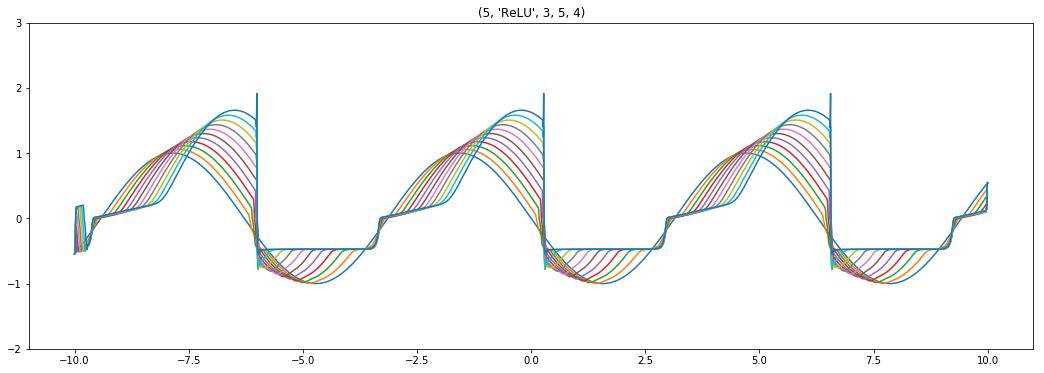

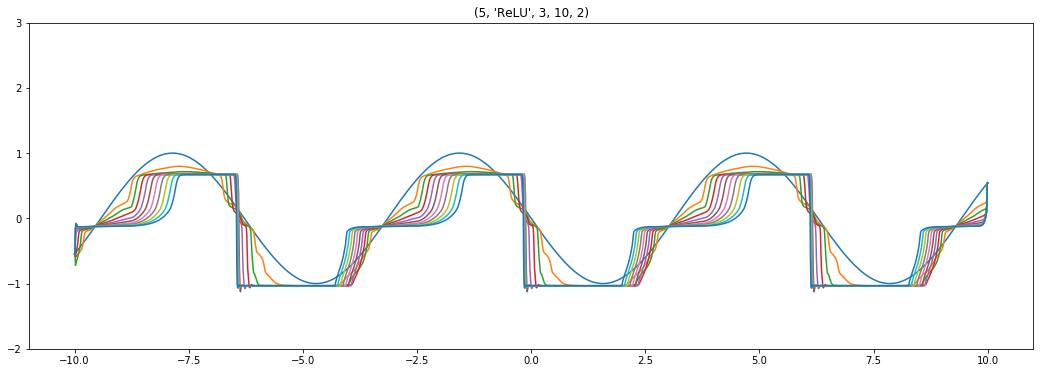

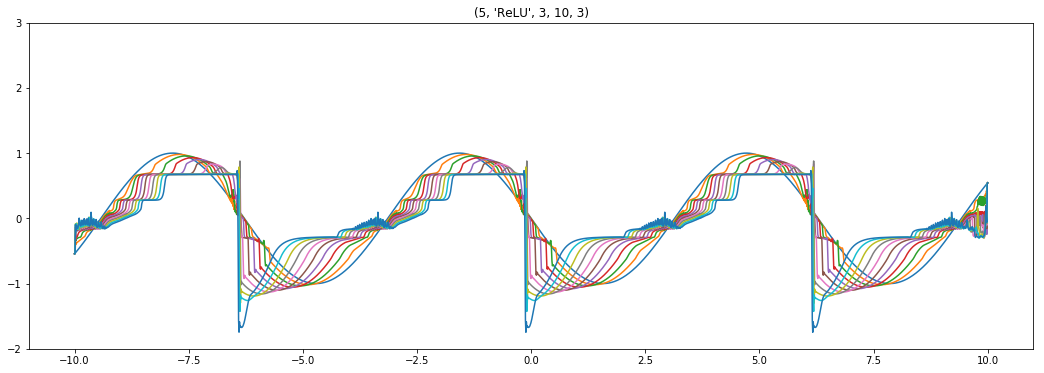

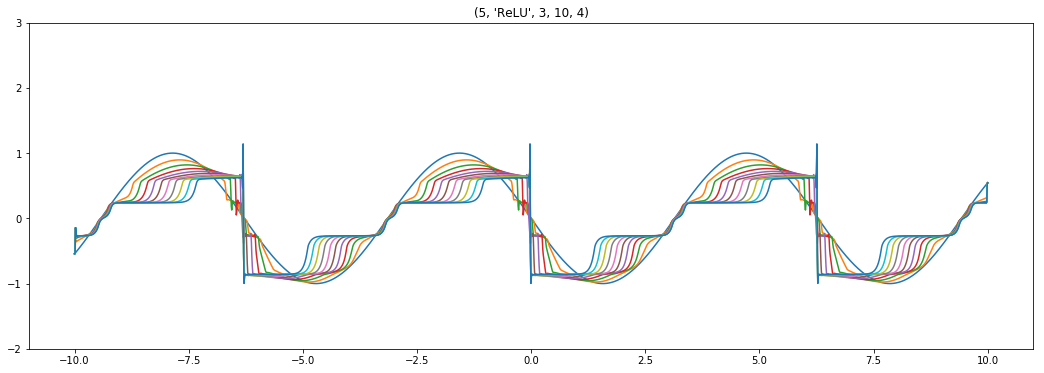

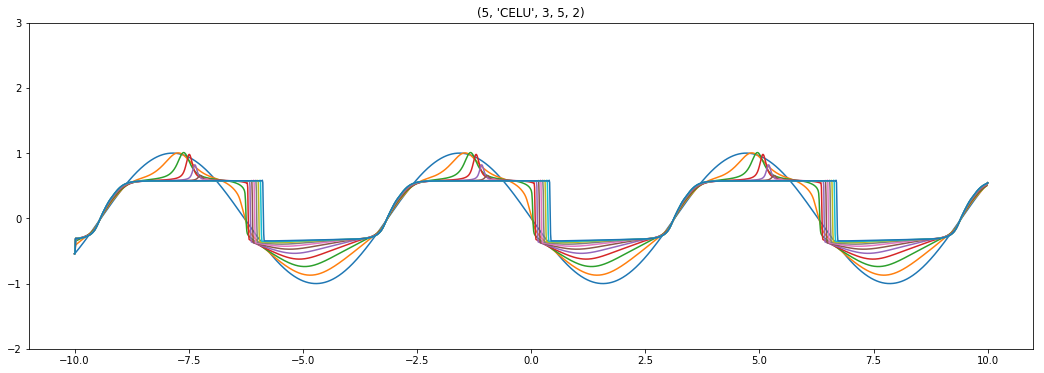

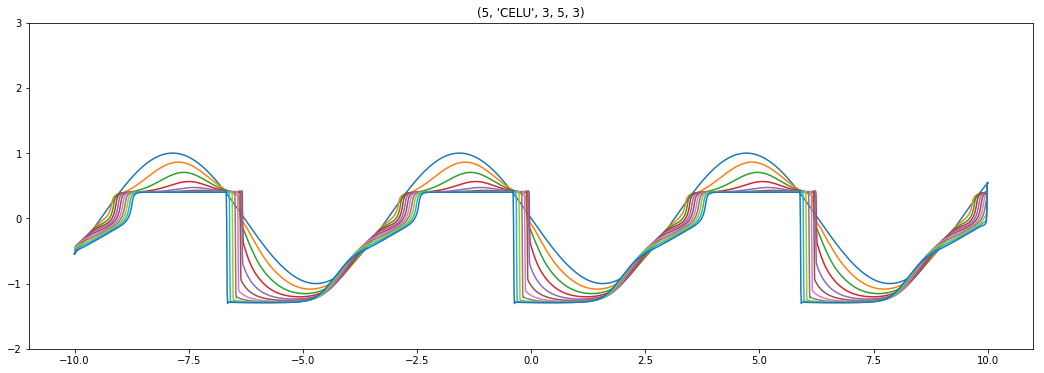

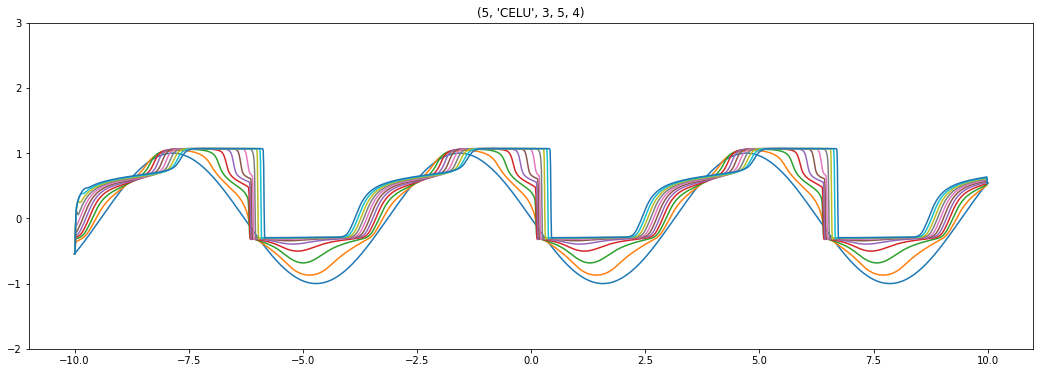

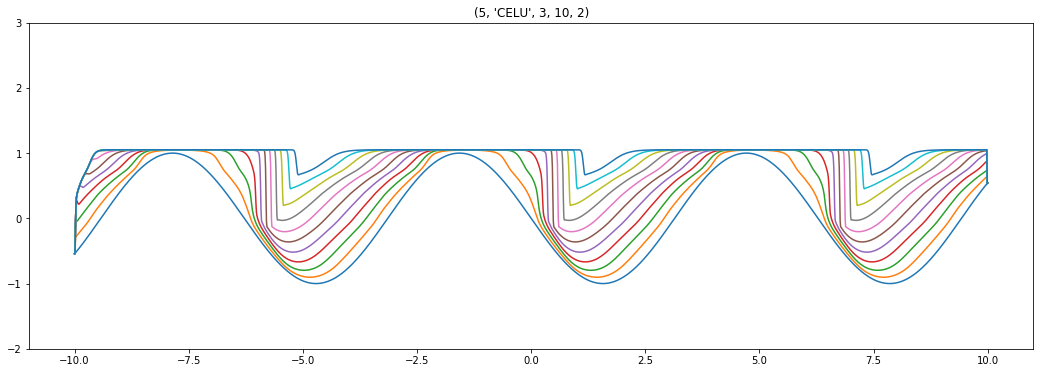

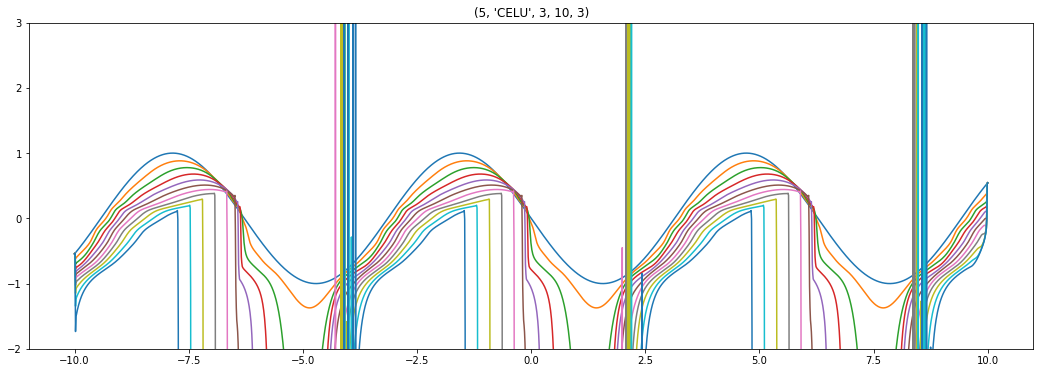

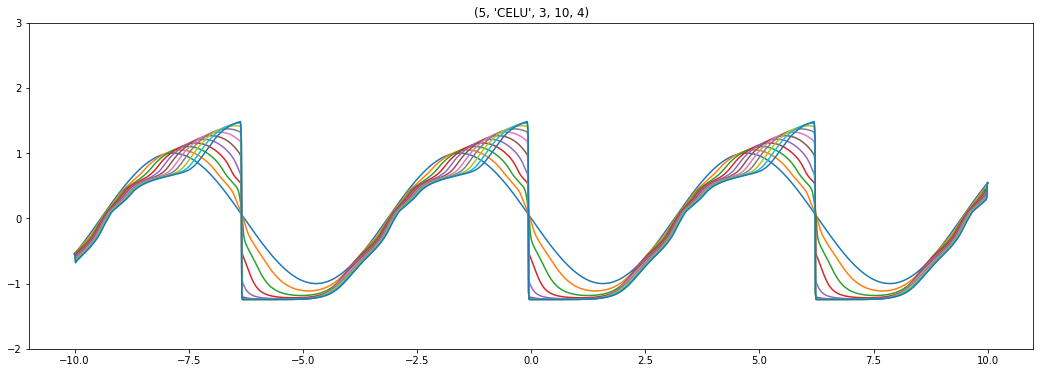

In [15]:
xs = np.linspace(-10,10,2000)
u0 = -np.sin(xs)
for i,(N,S) in enumerate(stash.items()):
    plt.figure(figsize=(18,6))
    plt.ylim((-2,3))
    #plt.xlim((0,2000))
    do_an_unknown_path(S['model'], torch.tensor(u0,dtype=torch.float32).to(device), 1000, x=xs)
    plt.title(N)
    plt.show()